The goal of this notebook is to study the current increase of house prices in Dublin and to understand what is driving this increase. Specifically, we wish to answer the question as to whether this is another housing bubble or not.

Firstly, we shall attempt to model the average house price in Dublin based purely on the number of (occupied) properties per capita. Secondly, we shall use the 5 criteria listed in 'https://www.forbes.com/sites/trulia/2016/11/15/signs-your-local-real-estate-market-is-a-bubble/#4d7f62397744' to check whether or not the current market in Dublin is a housing bubble or not. We shall also check the housing bubble of the late 1990s in Dublin as a control.

# Plotting the average property price by year

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

We now read in 2 Excel files; the first contains the average new house price by area and year/quarter and the second contains the average second-hand house price by area and year/quarter. We obtained this data from 'http://www.housing.gov.ie/housing/statistics/house-prices-loans-and-profile-borrowers/house-price-statistics'.

In [2]:
#specify the filenames
filenames = ['n_price_yr.xlsx', 'sh_price_yr.xlsx']

#build a list comprehension of dataframes
dataframes = [pd.read_excel(file, header=1, index_col=0) for file in filenames]

#strip whitespace
dataframes = [df.rename(columns=lambda x: x.strip()) for df in dataframes]
#keep only the Dublin column
dataframes = [pd.DataFrame(df.Dublin) for df in dataframes]

#modify the column header to clarify whether we are talking about new or second-hand properties
for n in range(len(dataframes)):
    #modify the column headers
    dataframes[n].columns = dataframes[n].columns + '_' + filenames[n][0]
    #convert the indices to strings
    dataframes[n].index = dataframes[n].index.map(str)
    
#we remove these last 6 unwanted rows and convert the prices to thousands of €
dataframes = [df.loc['1974':'2015'] / 1000 for df in dataframes]

#we now merge the two dataframes.
df_c = pd.concat(dataframes, axis=1, join='inner')

We now plot, for both the new and second-hand data, the average house prices over time. We then plot smoothed versions of this data.

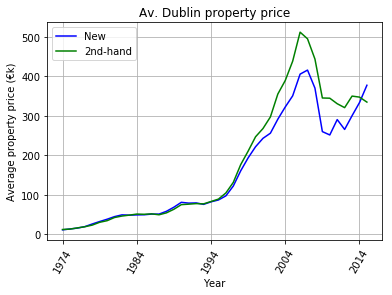

In [14]:
plt.plot(df_c.Dublin_n.values, label='New', c='b')
plt.plot(df_c.Dublin_s.values, label='2nd-hand', c='g')
plt.title('Av. Dublin property price')
plt.legend()
plt.ylabel('Average property price (€k)')
plt.xlabel('Year')
plt.xticks(range(0, len(df_c), 10), df_c.index.tolist()[::10], rotation=60)
plt.grid()

plt.show()

We now plot the rate of change of the property prices, by year.

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


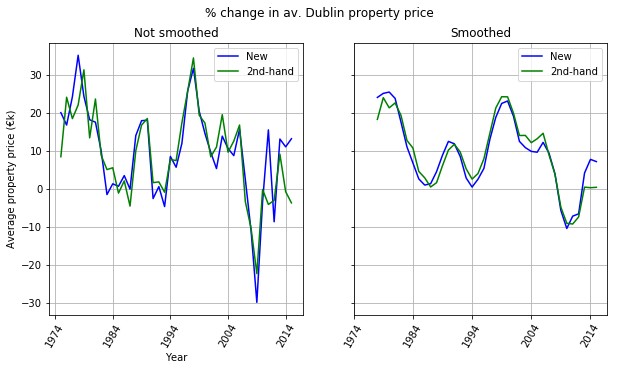

In [13]:
#define % change
roc_df = df_c.pct_change() * 100

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

plt.suptitle('% change in av. Dublin property price')

ax1.plot(roc_df.Dublin_n.values, label='New', c='b')
ax1.plot(roc_df.Dublin_s.values, label='2nd-hand', c='g')
ax1.set_title('Not smoothed')
ax1.legend()
ax1.set_ylabel('Average property price (€k)')
ax1.set_xlabel('Year')
ax1.set_xticks(range(0, len(roc_df), 10))
ax1.set_xticklabels(roc_df.index.tolist()[::10], rotation=60)
ax1.grid()

ax2.plot(np.array(pd.rolling_mean(roc_df.Dublin_n.values, window=4)), label='New', c='b')
ax2.plot(np.array(pd.rolling_mean(roc_df.Dublin_s.values, window=4)), label='2nd-hand', c='g')
ax2.set_title('Smoothed')
ax2.legend()
ax1.set_xlabel('Year')
ax2.set_xticks(range(0, len(roc_df), 10))
ax2.set_xticklabels(roc_df.index.tolist()[::10], rotation=60)
ax2.grid()

plt.show()

# Plotting property price vs. households/capita

The government has declared that the current increase in property prices is driven by a shortage of houses. We will investigate this by predicting house prices using the number of residences per capita.

As a control, we shall first see how this fares for the 'Celtic Tiger' period. We now read in data on the numbers of households in Dublin. This data was obtained from 'http://www.cso.ie/px/pxeirestat/statire/SelectVarVal/Define.asp?Maintable=CNA33&Planguage=0'. We also read in population data, obtained from 'http://www.cso.ie/px/pxeirestat/statire/SelectVarVal/Define.asp?MainTable=A0102&PLanguage=0&PXSId=0'.

In [23]:
#read in the CSV files
households, pop = pd.read_csv('households.csv', skiprows=3), pd.read_csv('pop.csv', skiprows=2)
#select the relevant data
households, pop = households.iloc[2], pop.iloc[3, 2:]
#omit missing data
households = households[households != '..'].iloc[3:]

#define a house per capita dataframe
house_pc = (pop / households).dropna().astype('float64')

#append this to the df_c dataframe
df_c['house_pc'] = house_pc

#display the first 10 rows of df_c
df_c.head(10)

,Dublin_n,Dublin_s,house_pc
1974,10.942603,11.776821,NaN
1975,13.136710,12.773565,NaN
1976,15.342245,15.850140,NaN
1977,19.054959,18.778156,NaN
1978,25.745209,22.920042,NaN
1979,32.005018,30.091523,3.754286
1980,37.821688,34.129290,NaN
1981,44.456070,42.193396,3.702655
1982,48.886186,45.912459,NaN
1983,48.168784,48.248777,NaN


## Filling in the 'missing' values

It is clear that we are 'missing' many values for the house_pc column. This is due to the fact that data is only available for census years. We would like to fill in these values: let us begin by plotting the properties per capita by year.

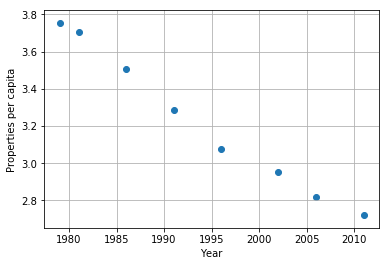

In [88]:
#drop the null values
df_cfin = df_c.dropna()

plt.scatter(x=df_cfin.index.values.astype('int'), y=df_cfin.house_pc.values)
plt.xlabel('Year'), plt.ylabel('Properties per capita')
plt.grid()

plt.show()

This looks highly linear. As such, let us fit this using linear regression.

0.986165165641


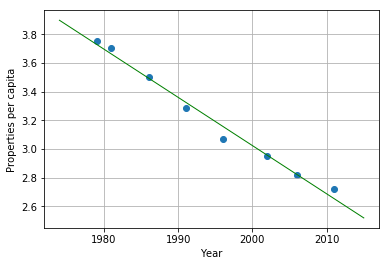

In [110]:
#drop the null values
df_cfin = df_c.dropna()

#initiate LinearRegression()
reg = LinearRegression()
#define the predictors and response
X, y = df_cfin.index.values.astype('int').reshape(-1,1), df_cfin.house_pc
#fit the regression model
reg.fit(X, y)

#define a prediction space
prediction_space = np.arange(1974, 2016).reshape(-1,1)
#obtain the predictions of the regression model for the response
y_pred = reg.predict(prediction_space)
#print the r^2 score of the model
print(reg.score(X, y))

#plot the model and the data points
plt.scatter(x=df_cfin.index.values.astype('int'), y=df_cfin.house_pc.values)
plt.plot(prediction_space, y_pred, color='green', linewidth=1)
plt.xlabel('Year'), plt.ylabel('Properties per capita')
plt.grid()

plt.show()

This is a very good fit. We now use this regression fit to obtain values for the 'missing' years in the df_c dataframe.

0.983673374534


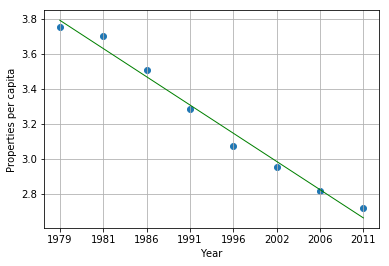

In [78]:
#drop the null values
df_cfin = df_c.dropna()

#initiate LinearRegression()
reg = LinearRegression()
#define the predictors and response
X, y = np.arange(len(df_cfin)).reshape(-1,1), df_cfin.house_pc
#fit the regression model
reg.fit(X, y)

#define a prediction space
prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)
#obtain the predictions of the regression model for the response
y_pred = reg.predict(prediction_space)
#print the r^2 score of the model
print(reg.score(X, y))

#plot the model and the data points
plt.scatter(x=range(len(df_cfin)), y=df_cfin.house_pc.values)
plt.plot(prediction_space, y_pred, color='green', linewidth=1)
plt.xticks(range(0,len(df_cfin)), df_cfin.index.values)
plt.xlabel('Year'), plt.ylabel('Properties per capita')
plt.grid()

plt.show()

In [162]:
#fill in the missing values and assign it as a column in df_c
df_c['house_pc_fill'] = df_c['house_pc'].fillna(y_pred_df.house_pc_int, axis=0)

We now plot the house prices in Dublin versus the properties per capits in Dublin and fit them using a linear regression model again.

C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()
C:\Users\Michael\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


0.822846095266
0.785754493849


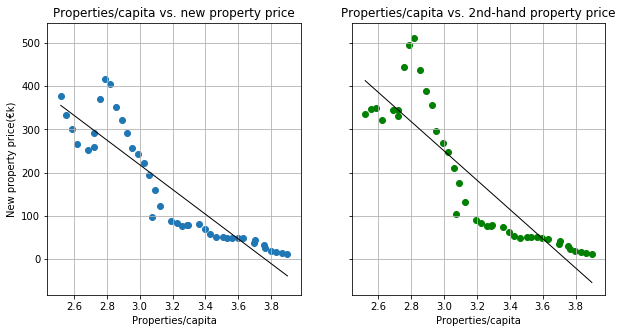

In [166]:
lin_reg = LinearRegression()

X, y = df_c.house_pc_fill.reshape(-1, 1), df_c.Dublin_n.reshape(-1, 1)

lin_reg.fit(X, y)

prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)
y_pred = lin_reg.predict(prediction_space)
print(lin_reg.score(X, y))

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

ax1.scatter(x=df_c.house_pc_fill, y=df_c.Dublin_n)
ax1.plot(prediction_space, y_pred, color='black', linewidth=1)
ax1.set_xlabel('Properties/capita')
ax1.set_ylabel('New property price(€k)')
ax1.set_title('Properties/capita vs. new property price')
ax1.grid()

X, y = df_c.house_pc_fill.reshape(-1, 1), df_c.Dublin_s.reshape(-1, 1)

lin_reg.fit(X, y)

prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)
y_pred = lin_reg.predict(prediction_space)
print(lin_reg.score(X, y))

ax2.scatter(x=df_c.house_pc_fill, y=df_c.Dublin_s, c='g')
ax2.plot(prediction_space, y_pred, color='black', linewidth=1)
ax2.set_xlabel('Properties/capita')
ax2.set_title('Properties/capita vs. 2nd-hand property price')
ax2.grid()

plt.show()

This isn't the best fit. There appear to be multiple 'phases', however, in which the relationship could be modelled well with a linear model. Perhaps if these correspond to separate time periods, then we could split up these time periods.
There are 3 avenues which I will pursue:

* labelling the plots by time and perhaps splitting up these 'phases' and considering them separately
* fitting with a higher order polynomial (rather than a linear polynomial)
* find a way to include the information as to how the average number of people per property is changing, e.g. plot 'property people per capita', that is the average number of people per property multiplied by the number of properties and divided by the population

# Future directions

* consider the rental sector
* sort out ambiguity between Dublin city and county
* combined new/second-hand figures
* 'fill in' intermediate population figures
* number of people per household